# 5. Frequent Item Set - Data Mining Introduction

## 5.1 Association rules

Body -> Head \[support, confidence\]. 

Find all rules A => B \[s, c\] s.t s > s_min, c > c_min using Apriori algorithm.

In [18]:
from operator import itemgetter
import numpy as np

The **[Apriori Algorithm](https://en.wikipedia.org/wiki/Apriori_algorithm)** identifies frequent combinations of items by extending them to larger and larger itemsets (see the generate_candidates function) as long as they appear sufficiently often in a list of transactions.

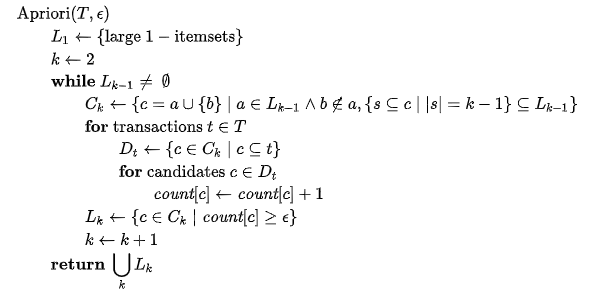

### 5.1 **Support:**

The support of the itemset $X$ with respect to the list of transactions $T$ 

* proportion of transactions $t$ in the dataset which contains the itemset $X$

$$\mathrm{supp}(X) = \frac{|\{t \in T; X \subseteq t\}|}{|T|}$$  

In [7]:
"""
Format the transaction dataset.
Expect a list of transaction in the format:
[[1, 3, 4], [2, 3, 5], [1, 2, 3, 5], ...]
"""
def preprocess(dataset):
    unique_items = set()
    for transaction in dataset:
        for item in transaction:
            unique_items.add(item)
       
    # Converting to frozensets to use itemsets as dict key
    unique_items = [frozenset([i]) for i in list(unique_items)]
    
    return unique_items,list(map(set,dataset))


"""
Generate candidates of length n+1 from a list of items, each of length n.

Example:
[{1}, {2}, {5}]          -> [{1, 2}, {1, 5}, {2, 5}]
[{2, 3}, {2, 5}, {3, 5}] -> [{2, 3, 5}]
"""
def generate_candidates(Lk):
    output = []

    # We generate rules of the target size k
    k=len(Lk[0])+1
    
    for i in range(len(Lk)):
        for j in range(i+1, len(Lk)): 
            L1 = list(Lk[i])[:k-2]; 
            L2 = list(Lk[j])[:k-2]
            L1.sort(); 
            L2.sort()

            # Merge sets if first k-2 elements are equal
            # For the case of k<2, generate all possible combinations
            if L1==L2: 
                output.append(Lk[i] | Lk[j])

    return output


"""
Print the results of the apriori algorithm
"""
def print_support(support,max_display=10,min_items=1):
    print('support\t itemset')
    print('-'*30)
    filt_support = {k:v for k,v in support.items() if len(k)>=min_items}
    for s,sup in sorted(filt_support.items(), key=itemgetter(1),reverse=True)[:max_display]:
        print("%.2f" % sup,'\t',set(s))

In [8]:
"""
Run the apriori algorithm

dataset     : list of transactions
min_support : minimum support. Itemsets with support below this threshold
              will be pruned.
L : Frequent item sets. L[0] : [{'a'}, {'b'}]; L[1]: [{'a', 'b'}, {'c', 'd'}]
Support data: Dictioary of frequent itemsets with their corresponding support.
"""
def apriori(dataset, min_support = 0.5):
    unique_items,dataset = preprocess(dataset)
    L1, supportData      = get_support(dataset, unique_items, min_support) # L1 = {'a'} {'b'} {'c'}
    L = [L1]
    k = 0
    
    while True:
        Ck       = generate_candidates(L[k]) # Union 2 single itemset to a composite itemset {'a'}, {'b'} => {'a', 'b'}
        Lk, supK = get_support(dataset, Ck, min_support)
        
        # Is there itemsets of length k that have the minimum support ?
        if len(Lk)>0:
            supportData.update(supK) # rewrite the values in support dict with newly calculated support 
            L.append(Lk) 
            k += 1
        else:
            break # calculates, as min support augments, the itemsets that satitisfies condition
            
    return L, supportData

In [9]:
"""
Compute support for each provided itemset by counting the number of
its occurences in the original dataset of transactions.

dataset      : list of transactions, preprocessed using 'preprocess()'
Ck           : list of itemsets to compute support for. 
min_support  : minimum support. Itemsets with support below this threshold
               will be pruned.
              
output       : list of remaining itemsets, after the pruning step. 
support_dict : dictionary containing the support value for each itemset.
"""
def get_support(dataset, Ck, min_support):
    
    # This dictionary should contain the number of appearance of each itemset in the dataset.
    # Itemset in Ck are represented as frozensets and can directly be uses as dictionary keys.
    support_count = {}
    
    for transaction in dataset:
        for candidate in Ck:
            if candidate.issubset(transaction):
                if candidate in support_count:
                    support_count[candidate] += 1
                else:
                    support_count[candidate] = 1
    
    output = []
    support_dict = {}
    for key in support_count:
        # Calculate fraction of presence of itemset over all transactions
        support = support_count[key] / float(len(dataset))
        
        if support >= min_support:
            output.insert(0,key)
            
        support_dict[key] = support
    return output, support_dict

In [10]:
dataset = [ l.strip().split(',') for i,l in enumerate(open('notebooks/05.Frequent_Itemsets/groceries.csv').readlines())]
L,support = apriori(dataset,min_support=0.01)
print_support(support,10,min_items=2)

support	 itemset
------------------------------
0.07 	 {'whole milk', 'other vegetables'}
0.06 	 {'whole milk', 'rolls/buns'}
0.06 	 {'whole milk', 'yogurt'}
0.05 	 {'whole milk', 'root vegetables'}
0.05 	 {'other vegetables', 'root vegetables'}
0.04 	 {'yogurt', 'other vegetables'}
0.04 	 {'other vegetables', 'rolls/buns'}
0.04 	 {'whole milk', 'tropical fruit'}
0.04 	 {'whole milk', 'soda'}
0.04 	 {'rolls/buns', 'soda'}


### 5.2 **Confidence:**

After finding all the frequent itemsets, it's time to determine the rules.

* [association rule learning](https://en.wikipedia.org/wiki/Association_rule_learning) to better understand the **directionality of our computed frequent itemsets**. In other terms, we will have to infer if the purchase of one item generally implies the the purchase of another.

* confidence for a set of candidate rules H and prunes the rules that have a confidence below the specified threshold 

$$\mathrm{conf}(X \Rightarrow Y) = \mathrm{supp}(X \cup Y) / \mathrm{supp}(X)$$
 

Output for computing confidence:
```
H1: [frozenset({'napkins'}), frozenset({'whole milk'})]
freqSet: frozenset({'napkins', 'whole milk'}); X : frozenset({'whole milk'}); Y: frozenset({'napkins'})
freqSet: frozenset({'napkins', 'whole milk'}); X : frozenset({'napkins'}); Y: frozenset({'whole milk'})
```

The L list give all the itemset that has a support higher than the min_support, i.e. the proportion that the items in the itemset appear together in all transactions is high enough to create a rule. Then, we will try to find the direction of the rule: if it's A => B, or B => A by calculating the confidence.

In [11]:
"""
L              : itemsets
supportData    : dictionary storing itemsets support
min_confidence : rules with a confidence under this threshold should be pruned
"""
def generate_rules(L, supportData, min_confidence=0.7):  
    # Rules to be computed
    rules = []
    
    # Iterate over itemsets of length 2..N
    for i in range(1, len(L)):
        
        # Iterate over each frequent itemset
        for freqSet in L[i]:
            H1 = [frozenset([item]) for item in freqSet]
            
#             print("H1: {}".format(H1))
            
            # If the itemset contains more than 2 elements
            # recursively generate candidates 
            if (i+1 > 2):
                rules_from_consequent(freqSet, H1, supportData, rules, min_confidence)
                compute_confidence(freqSet, H1, supportData, rules, min_confidence)
            # If the itemsset contains 2 or less elements
            # conpute rule confidence
            else:
                compute_confidence(freqSet, H1, supportData, rules, min_confidence)

    return rules   

"""
freqSet        : frequent itemset
H              : candidate elements to create a rule
supportData    : dictionary storing itemsets support
rules          : array to store rules
min_confidence : rules with a confidence under this threshold should be pruned
"""
def rules_from_consequent(freqSet, H, supportData, rules, min_confidence=0.7):
    m = len(H[0])
    
#     print("H: {}".format(H))
    
    if (len(freqSet) > (m + 1)): 

        # create new candidates of size n+1 i.e. merge individual sets
        Hmp1 = generate_candidates(H)
        Hmp1 = compute_confidence(freqSet, Hmp1, supportData, rules, min_confidence)
        
        if (len(Hmp1) > 1):    #need at least two sets to merge
            rules_from_consequent(freqSet, Hmp1, supportData, rules, min_confidence)
"""
Print the resulting rules
"""
def print_rules(rules,max_display=10):
    print('confidence\t rule')
    print('-'*30)
    for a,b,sup in sorted(rules, key=lambda x: x[2],reverse=True)[:max_display]:
        print("%.2f" % sup,'\t',set(a),'->',set(b))

In [14]:
"""
Compute confidence for a given set of rules and their respective support

freqSet        : frequent itemset of N-element
H              : list of candidate elements Y1, Y2... that are part of the frequent itemset
supportData    : dictionary storing itemsets support
rules          : array to store rules
min_confidence : rules with a confidence under this threshold should be pruned
"""
def compute_confidence(freqSet, H, supportData, rules, min_confidence=0.7):
    prunedH = [] 
    
    for Y in H:
        # Compute X which is the frequent itemset minus the considered Y
        X           = freqSet - Y
        
#         print("freqSet: {}; X : {}; Y: {}".format(freqSet, X, Y))
        
        # Compute support for both terms
        support_XuY = supportData[freqSet]
        support_X   = supportData[X]    
        
        # Compute confidence
        conf        = support_XuY / support_X
        
        if conf >= min_confidence: 
            rules.append((X, Y, conf))
            prunedH.append(Y)
    return prunedH

In [15]:
rules=generate_rules(L,support, min_confidence=0.1)
print_rules(rules,10)

confidence	 rule
------------------------------
0.59 	 {'citrus fruit', 'root vegetables'} -> {'other vegetables'}
0.58 	 {'root vegetables', 'tropical fruit'} -> {'other vegetables'}
0.58 	 {'yogurt', 'curd'} -> {'whole milk'}
0.57 	 {'butter', 'other vegetables'} -> {'whole milk'}
0.57 	 {'root vegetables', 'tropical fruit'} -> {'whole milk'}
0.56 	 {'yogurt', 'root vegetables'} -> {'whole milk'}
0.55 	 {'other vegetables', 'domestic eggs'} -> {'whole milk'}
0.52 	 {'whipped/sour cream', 'yogurt'} -> {'whole milk'}
0.52 	 {'root vegetables', 'rolls/buns'} -> {'whole milk'}
0.52 	 {'other vegetables', 'pip fruit'} -> {'whole milk'}


## 5.2 FP-Tree : Association rule learning

**Frequent itemset discovery without candidate itemset generate**

Since generating all frequent itemset is not a scalable solution, there are alternatives:

- **Sampling**: taking **p x s** where p = probability to select each transaction T => form a subset, and choose frequent itemset with a lower support **p x s**. Need to take care of False +ve / False -ve (frequent in db but ignored)

- **Partitioning**: divide transactions in 1/p partitions and find itemsets with **p x s** min_support. An itemset = candidate if it's frequent in at lesat 1 partition.

A better solution is the **FP Growth** Algorithm.

See : https://github.com/enaeseth/python-fp-growth/blob/master/fp_growth.py

In [21]:
# LIFT = CONF(A->B) / SUPPORT(B)

def compute_lift(freqSet, H, supportData, rules, min_lift=0.7):
    prunedH = [] 
    
    for Y in H:
        # Compute X which is the frequent itemset minus the considered Y
        X           = freqSet - Y
        
#         print("freqSet: {}; X : {}; Y: {}".format(freqSet, X, Y))
        
        # Compute support for both terms
        support_XuY = supportData[freqSet]
        support_X   = supportData[X]
        
        # Compute support for Y : X=>Y as rule
        support_Y = supportData[Y]
        
        # Compute confidence
        conf        = support_XuY / support_X
        
        # Compute lift
        lift = conf / support_Y
        
        if lift >= min_lift: 
            rules.append((X, Y, lift))
            prunedH.append(Y)
    return prunedH

# 6. Clustering & Classification

## 6.1 K-means clustering:
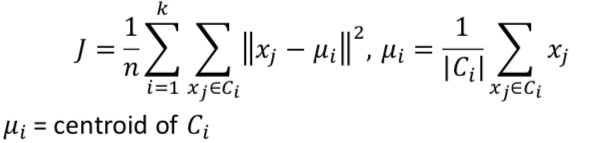
* O(tkn) where t= #iterations, k= #clusters, n= #pts
* local min

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn import preprocessing
from sklearn.datasets import make_blobs

np.random.seed(42)

%matplotlib inline

In [24]:
"""
Generate random 2D data points
X: Array of points [[x, y]]
"""
def gen_data(num_samples,num_blobs=3,random_state=42):
    # Generate isotropic Gaussian blobs for clustering.
    X, y = make_blobs(n_samples=num_samples, random_state=random_state, centers=num_blobs, cluster_std=5.0)
    return X,y

"""
Compute euclidean distance between a point and a centroid.
point,centroid: 1D Numpy array containing coordinates [x,y]
"""
def euclidean_distance(point, centroid):
    return np.sqrt(np.sum((point - centroid)**2))

def init_centroids(X,num_clusters):
    rand_indices = np.random.choice(X.shape[0], num_clusters,replace=False)
    return X[rand_indices,:]


"""
Assign objects to their closest cluster center according to the Euclidean distance function.
X: Array of points [[x, y]]
"""
def assign_points(X, centroids):
    labels = [] #
    for point in range(0, X.shape[0]):
        # Hint: you can use the function euclidean_distance(...) 
        #       to compute the distance between a point and 
        #       a centroid.
        distance = {}
        for centroid in range(0, centroids.shape[0]):
            distance[centroid] = euclidean_distance(X[point], centroids[centroid])
        
        sorted_distance = sorted(distance.items(), key=itemgetter(1))
        # why [0][0]: cuz sorted distance = [(0, 9.338486057329325), (1, 15.686930787053088), (2, 35.323976685460465)] 
        closest_centroid_index = sorted_distance[0][0]
        labels.append(closest_centroid_index)
    
    return np.array(labels)

"""
Update the position of a centroid according to the average position of the points
of that cluster.
X : array of points [[x, y] [x, y]]
labels: array same len as points, with label number [1, 2, 3, ...]
"""
def compute_centroids(X, labels, num_clusters):
    centroids = np.array([X[labels == i].mean(0) for i in range(num_clusters)])
    return centroids

"""
Runs one instance of k-means
X:            input data of shape Mx2, M the number of examples
num_clusters: number of clusters to compute
"""
def k_means(X, num_clusters):

    # Initialize centroids to randomly chosen data points
    centroids  = init_centroids(X,num_clusters)

    # Bookkeeping
    num_iter  = 0
    positions = [centroids]
    
    while True:
        
        labels = assign_points(X, centroids)
        
        new_centroids = compute_centroids(X, labels, num_clusters)

        num_iter += 1
        
        # Termination criterion
        if np.all(centroids == new_centroids):
            break
            
        centroids = new_centroids
        positions.append(centroids)
        
    return [labels, centroids, num_iter, positions]

In [53]:
num_samples = 150
num_blobs   = 3
X,y = gen_data(num_samples,num_blobs=num_blobs)

total_iterations = 10
num_clusters     = 3
[cluster_label, new_centroids, num_iter, positions] = k_means(X,num_clusters)
print("Convergence in %i iteration(s)" % num_iter)

Convergence in 10 iteration(s)


## 6.2 DBScan clustering
* 1 scan
* Need inital set of core points v_core, epsilon = radius, and u= min # of points in neighborhood so the pt can be considered as a core point

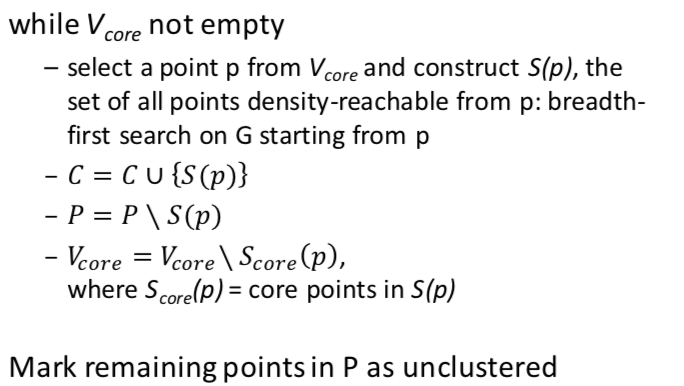

Example: with epsilon = 1, u = 3 (need 3 points in neighborhood of radius 1) .
Black points: core
White points: Border

<img src="notebooks/06.Clustering/sol1.png" width="400">

In [54]:
import numpy as np

def find_neighbors(D, P, eps):
    """
    Find all points in dataset `D` within distance `eps` of point `P`.
    
    This function calculates the distance between a point P and every other 
    point in the dataset, and then returns only those points which are within a
    threshold distance `eps`.
    """
    neighbors = []
    
    # For each point in the dataset...
    for Pn in range(0, len(D)):
        
        # If the distance is below the threshold, add it to the neighbors list.
        if np.linalg.norm(D[P] - D[Pn]) < eps:
            neighbors.append(Pn)
            
    return neighbors # return neighbors points

In [55]:
"""
Grow a new cluster with label `C` from the seed point `P` with BFS.

This function searches through the dataset to find all points that belong
to this new cluster. When this function returns, cluster `C` is complete.

Parameters:
  `D`      - The dataset (a list of vectors)
  `labels` - List storing the cluster labels for all dataset points
  `core`      - Index of the seed point for this new cluster
  `neighbors` - All of the neighbors of `P`
  `cluster_label`      - The label for this new cluster.  
  `eps`    - Threshold distance
  `minpts` - Minimum required number of neighbors
"""
def growCluster(D, labels, core, neighbors, cluster_label, eps, minpts):

    # Assign the cluster label to the seed point.
    labels[core] = cluster_label
    
    # BFS each of the neighbors using a FIFO queue
    i = 0
    while i < len(neighbors):
        # Get next neighbor from list
        current_neighbor = neighbors[i]
        
        # If Pn was labelled NOISE(-1) during the seed search, then we
        # know it's not a core point (it doesn't have enough neighbors), so
        # make it a leaf point of cluster C and move on.
        if labels[current_neighbor] == -1:
            labels[current_neighbor] = cluster_label
        
        # No label yet on current_neighbor
        elif labels[current_neighbor] == 0:
            labels[current_neighbor] = cluster_label
            
            neighbor_neighbors = find_neighbors(D, current_neighbor, eps)
            
            # Enough neighbor to be a core point => add to FIFO queue for furter search
            if len(neighbor_neighbors) >= minpts:
                neighbors += neighbor_neighbors
        
        i += 1

In [56]:
"""
Cluster the dataset `D` using the DBSCAN algorithm.

MyDBSCAN takes a dataset `D` (a list of vectors), a threshold distance
`eps`, and a required number of points `MinPts`.

It will return a list of cluster labels. The label -1 means noise, and then
the clusters are numbered starting from 1.

#    -1 - Indicates a noise point
#     0 - Means the point hasn't been considered yet.
"""
def DBScan(D, eps, minpts): 
    # Initially all labels are 0.    
    labels = [0]*len(D)

    # C is the ID of the current cluster.    
    current_cluster_label = 0
    
    # This outer loop is just responsible for picking new core points
    # ('P' is the index of the datapoint, rather than the datapoint itself.)
    for pt_index in range(0, len(D)):
    
        # If the point's label is not 0 (i.e. clustered), continue to the next point.
        if not (labels[pt_index] == 0):
            continue
        
        # Find all of P's neighboring points.
        neighbors = find_neighbors(D, pt_index, eps)
        
        # If the number is below MinPts, this point is noise. 
        # A NOISE point may later be picked up by another cluster as a boundary point (this is the only
        # condition under which a cluster label can change
        if len(neighbors) < minpts:
            labels[pt_index] = -1   
        else: 
            current_cluster_label += 1 
            growCluster(D, labels, pt_index, neighbors, current_cluster_label, eps, minpts)
    
    # All data has been clustered!
    return labels

In [73]:
num_samples = 150
num_blobs   = 3
X,y = gen_data(num_samples,num_blobs=num_blobs)

labels = DBScan(X, 3, 7)

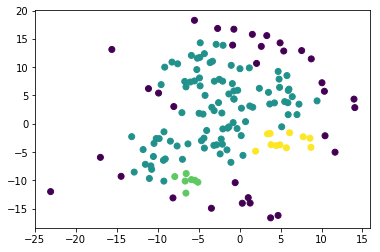

In [74]:
_ = plt.scatter(X[:, 0], X[:, 1], c=labels)

## 6.3 Decision tree classification

* Node: test on 1 attribute
* Branch : attribute value
* Leaf: class label

**Uncertainty**:
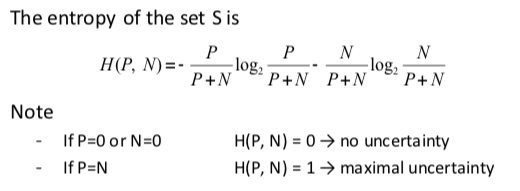

The splits in the decision tree is based on **Information Gain**:
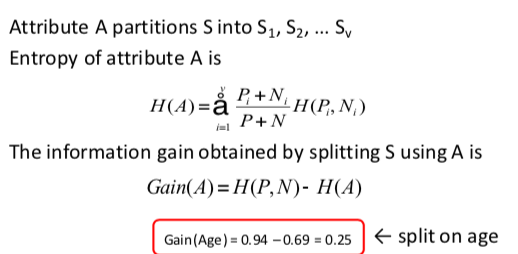

**Pruning to stop partitioning:**
* Stop splitting a node when a large portion of samples is +ve / -ve
* Minimum Description length : L(M) + L(D|M) i.e. len(tree description: #nodes, arcs) + len(#misclassification)
* Build full tree, take node out, see if accuracy drops

* Interpretability
* Non linear
* Easy to overfit


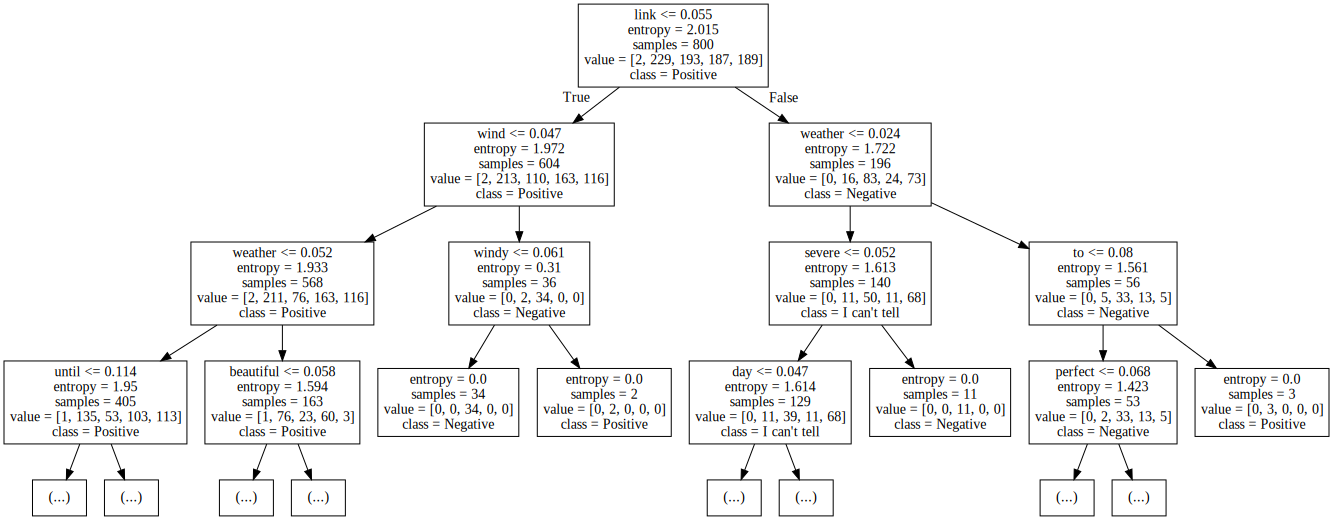

In [56]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import graphviz
#TfidfTransformer: Transform a count matrix to a normalized tf or tf-idf representation

# See split_data below
data = pd.read_csv('notebooks/07.Classification/data/weather-non-agg-DFE.csv')
agg_data = aggregate_weighted_majority(data[['tweet_id','emotion', 'tweet_body']], 'tweet_id', 'emotion', 'tweet_body')

x_train, x_test, y_train, y_test = split_data(agg_data, ratio=0.2, x_col='tweet_body', y_col='emotion')

class_names = data.emotion.unique().tolist()

# TODO: build a new pipeline with the TfidfTransformer
def build_tfid_pipeline(classifier_fn,x_train,y_train):
    count_vect = CountVectorizer(ngram_range=(1, 2),max_df=0.5)
    pipeline = Pipeline([
        ('count_vectorizer', count_vect),
        ('tfidtransformer', TfidfTransformer()),
        ('classifier', classifier_fn)
        ])
    pipeline.fit(x_train,y_train)
    return pipeline

# TODO: build the pipeline with the Decision Tree Classifier
pipeline = build_tfid_pipeline(DecisionTreeClassifier(criterion="entropy"), x_train, y_train)
# extract the classifier and the count_vectorizer from the pipeline
classifier= pipeline.get_params()['classifier']
count_vectorizer = pipeline.get_params()['count_vectorizer']
# TODO: Use export_graphviz to visualize the classifiers. You already have all the needed parameters.
# max_depth: The maximum depth of the representation
dot_data = export_graphviz(classifier, out_file=None, max_depth=3, 
                          feature_names=count_vectorizer.get_feature_names(), class_names=class_names)

graph = graphviz.Source(dot_data) 
graph

## 6.4 Random forest - Bagging of decision trees

* **Bagging**, Stacking, Boosting
* Can model complex decisions without overfitting
* Hard to interpret

See: https://github.com/Sytta/ADA2018-Homework-CANada/blob/master/04%20-%20Observational%20Studies%20and%20Applied%20ML/Homework%204.ipynb

In [ ]:
def get_accuracy(tx_tr, ty_tr, tx_te, ty_te, threshold=0.5):
    model = logistic.fit(tx_tr, ty_tr)
    y_pred = np.where(model.predict_proba(tx_te)[:,1] > threshold, 1, 0)
    cm = confusion_matrix(ty_te, y_pred)
    accuracy = (cm[1,1] + cm[0,0])/ cm.sum() 
    return accuracy

def build_k_indices(y, k_fold, seed=1):
    """build k indices for k-fold."""
    num_row = y.shape[0]
    interval = int(num_row / k_fold)
    np.random.seed(seed)
    indices = np.random.permutation(num_row)
    k_indices = [indices[k * interval: (k + 1) * interval] for k in range(k_fold)]
    return np.array(k_indices)

# 5 fold cross-validation
def cross_validation(y_tr, x_tr, rfc=None, use_rfc=False):
    """perform 5 fold cross_validation"""
    x = x_tr.values
    y = y_tr.values

    k_fold = 5
    accuracies = []
    # split data in k fold
    k_indices = build_k_indices(y_tr, k_fold)
    for k in range(k_fold):
        # get k'th subgroup in test, others in train
        te_indice = k_indices[k]
        tr_indice = k_indices[~(np.arange(k_indices.shape[0]) == k)].reshape(-1)
        # Split into x,y test (1/5) / x,y train (4/5)
        ty_te = y[te_indice]
        ty_tr = y[tr_indice]
        tx_te = x[te_indice]
        tx_tr = x[tr_indice]
        # get accuracy
        if use_rfc:
            accuracy = get_rfc_accuracy(tx_tr, ty_tr, tx_te, ty_te, rfc)
        else:
            accuracy = get_accuracy(tx_tr, ty_tr, tx_te, ty_te)
        accuracies.append(accuracy)
    return sum(accuracies)/len(accuracies)

In [ ]:
def grid_search(y_tr, x_tr, n_estimators, max_depths):
    """Algorithm for grid search."""
    accuracies = dict()
    # compute loss for each combination of w0 and w1.
    for i, estimator in enumerate(n_estimators):
        for j, depth in enumerate(max_depths):
            rfc = RandomForestClassifier(n_estimators=estimator, max_depth=depth)
            accuracies[(estimator, depth)] = cross_validation(y_tr, x_tr, rfc, use_rfc=True)
            print("Accuracy: {} for max_depth {}, n_estimator {}".format(accuracies[(estimator, depth)], depth, estimator))
    return accuracies


def get_rfc_accuracy(tx_tr, ty_tr, tx_te, ty_te, rfc):
    model = rfc.fit(tx_tr, ty_tr)
    y_pred = model.predict(tx_te)
    cm = confusion_matrix(ty_te, y_pred)
    accuracy = (cm[1,1] + cm[0,0])/ cm.sum() 
    return accuracy


n_estimators = [1, 10, 50, 100]
max_depths = [1, 10, 50, 100]
accuracies = grid_search(y_tr, x_tr, n_estimators, max_depths)

# Find the best parameters for random forest
best_param = max(accuracies, key=accuracies.get)
print("The best parameters (n_estimator, max_depths) : {}".format(best_param))

# Train random forest with best parameters
randomforest = RandomForestClassifier(n_estimators = 100, max_depth = 10)
rf_model = randomforest.fit(x_tr, y_tr)
rf_y_pred = rf_model.predict(x_te)
cm_rf = confusion_matrix(y_te, rf_y_pred)
rf_accuracy, rf_precision_pos, rf_precision_neg, rf_recall_pos, rf_recall_neg, rf_F1_pos, rf_F1_neg = test_scores(x_te, y_te, 0.5, rf_model, False)

# 7. Classification Pipeline

In [46]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings('ignore')

from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import graphviz

from sklearn.metrics import precision_recall_fscore_support,classification_report, confusion_matrix


In [33]:
"""
Return the majority voted 
agg_col : tweet_id
type_col : emotion
value_col : tweet_body
"""
def aggregate_weighted_majority(df, agg_col, type_col, value_col):
    # TODO: Aggregate with Majority weighted algorithm
    agg_data = df.groupby(df[agg_col]).agg({
        type_col: lambda group: group.value_counts().index[0], # value counts all possible values in decreasing order
        value_col: lambda group: list(group)[0] # take the first message of each group (should all be the same)
    })
    
    return agg_data

In [34]:
def remove_stopwords(x_train, stop):
    cleaned_x_train = []
    for phrase in x_train:
        words = phrase.split()
        resultwords  = [word for word in words if word.lower() not in stop]
        result = ' '.join(resultwords)
        cleaned_x_train.append(result)
    
    return np.array(cleaned_x_train)

In [97]:
"""
Split data into train, test set
x_col : feature column (tweet_body)
y_col : to predict column (emotion)
"""
def split_data(data, ratio, x_col, y_col, seed=42):
    train_data, test_data = train_test_split(data, test_size=ratio, random_state=seed)
    
    x_train = train_data[x_col].values
    y_train = train_data[y_col].values
    x_test = test_data[x_col].values
    y_test = test_data[y_col].values
    
    return x_train, x_test, y_train, y_test


def split_data2(x, y, ratio, seed=1):
    """split the dataset based on the split ratio."""
    # set seed
    np.random.seed(seed)
    # generate random indices
    num_row = len(y) # = len(x), both are 50
    indices = np.random.permutation(num_row)
    #print(indices, '\n\n')
    index_split = int(np.floor(ratio * num_row)) # = 40 if given 0.8
    index_tr = indices[: index_split]
    #print(index_tr, '\n\n')
    index_te = indices[index_split:]
    # create split
    x_tr = x[index_tr]
    x_te = x[index_te]
    y_tr = y[index_tr]
    y_te = y[index_te]
    return x_tr, x_te, y_tr, y_te

In [64]:
def build_pipeline(classifier_name,x_train,y_train, tf_idf=False, alpha=None):
    # Choose classifier
    if classifier_name == 'NaiveBayes':
        if alpha is None:
            classifier = MultinomialNB()
        else:
            classifier = MultinomialNB(alpha=alpha)
    elif classifier_name == 'SVM':
        classifier = SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)
    elif classifier_name == 'RandomForest':
        classifier = RandomForestClassifier(n_estimators=500, max_depth=50)
    else: #classifier_name == 'DecisionTree':
        # “gini” for the Gini impurity and “entropy” for the information gain.
        classifier = DecisionTreeClassifier(criterion="entropy")
    
    if tf_idf:
        pipeline = Pipeline([
            ('count_vectorizer',   CountVectorizer(ngram_range=(1, 2),max_df=0.5)),
            ('tfidf_transformer',  TfidfTransformer()),
            ('classifier',         classifier)
            ])
        pipeline.fit(x_train,y_train)
    else:
        pipeline = Pipeline([
            ('count_vectorizer',   CountVectorizer(ngram_range=(1, 2),max_df=0.5)),
            ('classifier',         classifier)
            ])
        pipeline.fit(x_train,y_train)
        
    return pipeline

In [48]:
# EVALUATION
def plot_confusion_matrix(y_test,y_predicted,labels):
    cm = confusion_matrix(y_test, y_predicted,labels =labels)

    figsize = (10,7)
    df_cm = pd.DataFrame(
        cm, index=class_names, columns=labels, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    return
    
def evaluate_classifier(pipeline, x_test, y_test, class_names):
    # get the predictions
    y_predicted = pipeline.predict(x_test)
    # generate the report
    # Build a text report showing the main classification metrics
    report = classification_report(y_test, y_predicted, labels=class_names)
    print(report)
    # plot the confusion matrix
    plot_confusion_matrix(y_test, y_predicted, class_names)
    # Get scores
    # support : The number of occurrences of each label in y_true.
    # same as classification report
#     precision, recall, fscore, support = precision_recall_fscore_support(y_test, y_predicted, labels=class_names)
    
    return

def most_informative_feature_for_class(vectorizer, classifier, classlabel, n=20):
    labelid = list(classifier.classes_).index(classlabel)
    print("Labelid: {}".format(labelid))
    # TODO: get the feature names from the vectorizer
    feature_names = vectorizer.get_feature_names()
    topn = sorted(zip(classifier.coef_[labelid], feature_names))[-n:]

    print("Classlabel \t Feature \t\t Coefficient")
    for coef, feat in topn:
        print(classlabel, '\t', feat, '\t\t', coef)

                                              precision    recall  f1-score   support

Neutral / author is just sharing information       0.95      0.65      0.77        55
                                    Positive       0.71      0.60      0.65        53
                                    Negative       0.48      0.85      0.61        47
      Tweet not related to weather condition       0.76      0.56      0.64        45
                                I can't tell       0.00      0.00      0.00         0

                                   micro avg       0.67      0.67      0.67       200
                                   macro avg       0.58      0.53      0.54       200
                                weighted avg       0.73      0.67      0.67       200



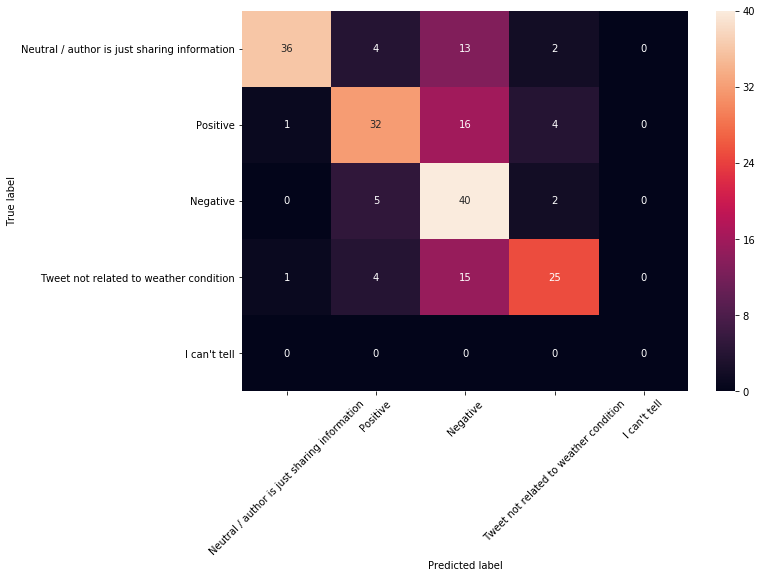

Labelid: 3
Classlabel 	 Feature 		 Coefficient
Positive 	 here 		 -6.641492950735728
Positive 	 on 		 -6.641492950735728
Positive 	 you 		 -6.641492950735728
Positive 	 be 		 -6.594972935100834
Positive 	 nice 		 -6.594972935100834
Positive 	 day 		 -6.550521172530001
Positive 	 of 		 -6.550521172530001
Positive 	 link 		 -6.467139563590949
Positive 	 this 		 -6.252028183974004
Positive 	 sunshine 		 -6.130667326969737
Positive 	 and 		 -6.022453742329504
Positive 	 sunny 		 -6.022453742329504
Positive 	 for 		 -5.9248152727655885
Positive 	 is 		 -5.9248152727655885
Positive 	 it 		 -5.81481437755126
Positive 	 to 		 -5.754189755734824
Positive 	 in 		 -5.734771669877723
Positive 	 weather 		 -5.279296141194897
Positive 	 mention 		 -5.197379018727011
Positive 	 the 		 -4.881994343725894


In [90]:
# Aggregate data according to weighted majority
data = pd.read_csv('notebooks/07.Classification/data/weather-non-agg-DFE.csv')
agg_data = aggregate_weighted_majority(data[['tweet_id','emotion', 'tweet_body']], 'tweet_id', 'emotion', 'tweet_body')

x_train, x_test, y_train, y_test = split_data(agg_data, ratio=0.2, x_col='tweet_body', y_col='emotion')

# remove stopwords in order to improve interpretability
stop = stopwords.words('english')
stop += ['rt','@mention:','@mention','link']

# Remove stop words
x_train_nostop = remove_stopwords(x_train, stop)
x_test_no_stop = remove_stopwords(x_test, stop)

# Get labels names from data
class_names = data.emotion.unique().tolist()

pipeline = build_pipeline('NaiveBayes',x_train, y_train)
evaluate_classifier(pipeline, x_test, y_test, class_names)

classifier = pipeline.get_params()['classifier']
count_vectorizer = pipeline.get_params()['count_vectorizer']
most_informative_feature_for_class(count_vectorizer,classifier,"Positive") #'Negative', or 'Neutral' also possible

# WHY IS IT FUCKING NOT CORRECT????



#### Cross-validation

in ML: https://github.com/Sytta/MachineLearningClass/blob/master/labs/ex04/solution/ex04.ipynb

In [58]:
# IN ML finding best weights to ridge_regression

x, y = load_data()

def ridge_regression(y, tx, lambda_):
    """implement ridge regression."""
    aI = 2 * tx.shape[0] * lambda_ * np.identity(tx.shape[1])
    a = tx.T.dot(tx) + aI
    b = tx.T.dot(y)
    return np.linalg.solve(a, b)

def build_k_indices(y, k_fold, seed):
    """build k indices for k-fold."""
    num_row = y.shape[0]
    interval = int(num_row / k_fold)
    np.random.seed(seed)
    indices = np.random.permutation(num_row)
    k_indices = [indices[k * interval: (k + 1) * interval] for k in range(k_fold)]
    return np.array(k_indices)

def cross_validation(y, x, k_indices, k, lambda_, degree):
    """return the loss of ridge regression."""
    # get k'th subgroup in test, others in train
    te_indice = k_indices[k]
    tr_indice = k_indices[~(np.arange(k_indices.shape[0]) == k)]
    tr_indice = tr_indice.reshape(-1)
    y_te = y[te_indice]
    y_tr = y[tr_indice]
    x_te = x[te_indice]
    x_tr = x[tr_indice]
    # form data with polynomial degree
    tx_tr = build_poly(x_tr, degree)
    tx_te = build_poly(x_te, degree)
    # ridge regression
    w = ridge_regression(y_tr, tx_tr, lambda_)
    # calculate the loss for train and test data
    loss_tr = np.sqrt(2 * compute_mse(y_tr, tx_tr, w))
    loss_te = np.sqrt(2 * compute_mse(y_te, tx_te, w))
    return loss_tr, loss_te, w

def cross_validation_demo():
    seed = 12
    degree = 7
    k_fold = 4
    lambdas = np.logspace(-4, 0, 30)
    # split data in k fold
    k_indices = build_k_indices(y, k_fold, seed)
    # define lists to store the loss of training data and test data
    rmse_tr = []
    rmse_te = []
    # cross validation
    for lambda_ in lambdas:
        rmse_tr_tmp = []
        rmse_te_tmp = []
        for k in range(k_fold):
            loss_tr, loss_te,_ = cross_validation(y, x, k_indices, k, lambda_, degree)
            rmse_tr_tmp.append(loss_tr)
            rmse_te_tmp.append(loss_te)
        rmse_tr.append(np.mean(rmse_tr_tmp))
        rmse_te.append(np.mean(rmse_te_tmp))

In [91]:
from sklearn.model_selection import ShuffleSplit
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import StratifiedKFold

# CROSS-VALIDATION: find a good alpha parameter for the MultinomialNB model.

# construct a new X and y 
X = np.concatenate((x_train_nostop, x_test_no_stop),axis=0)
y = np.concatenate((y_train, y_test),axis=0)  

# prepare for the cross validation 
kf = StratifiedKFold(n_splits=5,random_state=4)

alphas = [(i*0.1) for i in range(0,10)]

total_f1_pos = []
total_f1_neg = []

for a in alphas:
    f_score_pos = []
    f_score_neg = []
    for train_index, test_index in kf.split(X,y):
        
        # TODO: build the pipeline for the current alpha and the current training and testing set 
        pipeline = build_pipeline('NaiveBayes',X[train_index],y[train_index], alpha=a)
       
        y_predicted = pipeline.predict(X[test_index])
        
        report  = precision_recall_fscore_support(y[test_index], y_predicted)
        
        # let's get the f1_score value for the "Positive" and the "Negative" labels to plot them
        ind_pos = list(pipeline.classes_).index('Positive')
        ind_neg = list(pipeline.classes_).index('Negative')

        # report 0 is precision
        # report 2 is f-score
        fscore_positive = report[0][ind_pos]
        fscore_negative = report[0][ind_neg]
        
        f_score_pos += [fscore_positive]
        f_score_neg += [fscore_negative]
    # TODO: extend the arrays with the average  fscore_positive and fscore_negative repsectively.
    total_f1_pos += [np.mean(fscore_positive)]
    total_f1_neg += [np.mean(fscore_negative)]

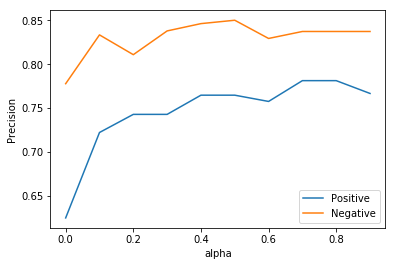

In [92]:
# HERE ARE THE ALPHA VALUES:
plt.plot(alphas,total_f1_pos,label='Positive')
plt.plot(alphas,total_f1_neg,label='Negative')

plt.xlabel('alpha')
plt.ylabel('Precision')
plt.legend()
plt.show()

# 8. Recommender system

**Based on ratings**: 
(weighted sum)
- User-based : (mean - personal rating) * sim(x,y) / sum of sim
"Users who are similar to you also liked…". 
**Based on the ratings of 1 item! We compare the similarity of the users who voted for this item, then aggregate!**

\begin{equation}
{r}_{x}(a) = \bar{r}_{x} + \frac{\sum\limits_{y \in N_{U}(x)} sim(x, y) (r_{y}(a) - \bar{r}_{y})}{\sum\limits_{y \in N_{U}(x)}|sim(x, y)|}
\end{equation}

- Item-based : sim(x,y) * rating of object / sum of sim
"Users who liked this item (movie) also liked …".
**based solely on the rating of the one user! we compare the similarity of the items he voted to predict what he would rate for the unknown item**

\begin{equation}
{r}_{x}(a) =  \frac{\sum\limits_{b \in N_{I}(a)} sim(a, b) r_{x}(b)}{\sum\limits_{b \in N_{I}(a)}|sim(a, b)|}
\end{equation}

1: Find the neighborhood of the item a N_u(a)

2: Aggregate all the ratings of the itme


**Based on metadata**:
- Content based:
Uses the tf-idf of the description of the objects to find the neighborhood. Aggregation function stays the same as Item-based.

In [101]:
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import sklearn
from sklearn.metrics.pairwise import pairwise_distances

In [100]:
# TODO fill the code to produce a data matrix
def create_data_matrix(data,n_users,n_items):
    """
        This function should return a numpy matrix with a shape (n_users, n_items). 
        Each entry is the rating given by the user to the item
    """
    data_matrix = np.zeros((n_users, n_items))
    
    for line in data.itertuples():
        # Pandas(Index=15795, user_id=222, item_id=200, rating=3, timestamp=878181647)
        # line[1] = user_id
        # line[2] = item_id
        # line[3] = rating
        data_matrix[line[1]-1, line[2]-1] = line[3]
    
    return data_matrix

In [107]:
def user_based_predict(ratings, similarity):
    filled_matrix = np.zeros((n_users, n_items))
    
    # compute the average ratings for each user
    tmp = train_data_matrix.copy()
    tmp[tmp == 0] = np.nan # put it to nan so when doing the average we don't count this object
    user_average_ratings = np.nanmean(tmp, axis=1) #average over each row cuz (user, item) matrix
    
    # loop over all the items
    for i in range(n_items):
        # get the users who rated this item
        ranked_users_indices = train_data_matrix[:,i].nonzero()[0] # get i'th column (all users rated item i)
        
        # for every user that rated the same item -> calculate rx(a) for each user x over same item a
        for u in range(n_users):
            numerator = 0
            denominator = 0
            
            # r_u(item i)
            # ys: Set of neighbors of user u => users
            for y in ranked_users_indices:
                numerator+=user_similarity[u,y]*(train_data_matrix[y,i]-user_average_ratings[y])
                denominator+=np.abs(user_similarity[u,y])
            if denominator>0:
                filled_matrix[u,i]= user_average_ratings[u]+ numerator/denominator
            else:
                filled_matrix[u,i]= user_average_ratings[u]

    # we ensure that the ratings are in the expected range
    filled_matrix.clip(0,5)
    return filled_matrix   

In [108]:
# TODO: Fill the code for predicting the ratings. 
# The output is a numpy matrix with the dimensions ((n_users,n_items)) and with the corresponding ranking at each cell.
def item_based_predict(ratings, similarity):
    filled_matrix = np.zeros((n_users, n_items))
    # loop over all the users
    for u in range(n_users):
        # get the items rated by this user => row 
        # non zero => we don't want items he didn't rate
        ranked_items_indices = train_data_matrix[u,:].nonzero()[0] #[0] cuz it returns array in array
        
        # calculate r_x(item i) for each item 
        for i in range(n_items):
            numerator = 0
            denominator = 0
            # calculating r_x(item i)
            # for all the items that the user voted == we are calculating over all items as neighborhood
            for j in ranked_items_indices: # for each item similar to the item i (rated by the same user)
                numerator += item_similarity[i,j]*train_data_matrix[u,j]
                denominator += np.abs(item_similarity[i,j])
            
            if denominator > 0:
                filled_matrix[u,i]= numerator/denominator
            else:
                # simply take a random rating in that case 
                filled_matrix[u,i]= np.random.randint(1,6)
    return filled_matrix

In [109]:
header = ['user_id', 'item_id', 'rating', 'timestamp']
df = pd.read_csv('notebooks/08.Recommender_Systems/ml-100k/u.data', sep='\t', names=header)

n_users = len(df.user_id.unique())
n_items = len(df.item_id.unique())

train_data, test_data = train_test_split(df, test_size=0.25, random_state= 42)

train_data_matrix= create_data_matrix(train_data, n_users, n_items)
test_data_matrix= create_data_matrix(test_data, n_users, n_items)

user_similarity = 1 - pairwise_distances(train_data_matrix, metric='cosine')
# Go through every item rated by a user, aggregate over user_similarity
user_prediction = user_based_predict(train_data_matrix, user_similarity)


# 1 - distance = similarity
# train_data_matrix.shape = (943, 1682) => we want each row = 1 item, so we transpose it
item_similarity = 1 - pairwise_distances(train_data_matrix.T, metric='cosine')
# Go through every user, get item
item_prediction = item_based_predict(train_data_matrix, item_similarity)


In [111]:
from sklearn.metrics import mean_squared_error
from math import sqrt
def rmse(prediction, ground_truth):
    prediction = prediction[ground_truth.nonzero()].flatten()
    ground_truth = ground_truth[ground_truth.nonzero()].flatten()

    return sqrt(mean_squared_error(prediction, ground_truth))

In [112]:
print ('User-based CF RMSE: ' + str(rmse(user_prediction, test_data_matrix)))
print ('Item-based CF RMSE: ' + str(rmse(item_prediction, test_data_matrix)))

User-based CF RMSE: 0.9554688083693528
Item-based CF RMSE: 1.0174300889515078


### Matrix Factorization

In [126]:
import scipy.io
import scipy.sparse as sp

In [114]:
def init_MF(train, num_features):
    """init the parameter for matrix factorization."""
        
    num_item, num_user = train.get_shape()

    user_features = np.random.rand(num_features, num_user)
    item_features = np.random.rand(num_features, num_item)

    # start by item features.
    item_nnz = train.getnnz(axis=1)
    item_sum = train.sum(axis=1)

    for ind in range(num_item):
        item_features[0, ind] = item_sum[ind, 0] / item_nnz[ind]
    return user_features, item_features

In [154]:
def compute_error(data, user_features, item_features, nz):
    """compute the loss (MSE) of the prediction of nonzero elements."""
    mse = 0
    for row, col in nz:
        item_info = item_features[:, row]
        user_info = user_features[:, col]
        mse += (data[row, col] - user_info.T.dot(item_info)) ** 2
        print(item_info, user_info, mse)
    return np.sqrt(1.0 * mse / len(nz))

In [139]:
def matrix_factorization_SGD(train, test):
    """matrix factorization by SGD."""
    # define parameters
    gamma = 0.01
    num_features = 20   # K in the lecture notes
    lambda_user = 0.1
    lambda_item = 0.7
    num_epochs = 20     # number of full passes through the train set
    errors = [0]
    
    # set seed
    np.random.seed(988)

    # init matrix
    user_features, item_features = init_MF(train, num_features)
    
    # find the non-zero ratings indices 
    nz_row, nz_col = train.nonzero()
    nz_train = list(zip(nz_row, nz_col))
    nz_row, nz_col = test.nonzero()
    nz_test = list(zip(nz_row, nz_col))

    print("learn the matrix factorization using SGD...")
    for it in range(num_epochs):        
        # shuffle the training rating indices
        np.random.shuffle(nz_train)
        
        # decrease step size
        gamma /= 1.2
        
        for d, n in nz_train:
            # update W_d (item_features[:, d]) and Z_n (user_features[:, n])
            item_info = item_features[:, d]
            user_info = user_features[:, n]
            err = train[d, n] - user_info.T.dot(item_info)
    
            # calculate the gradient and update
            item_features[:, d] += gamma * (err * user_info - lambda_item * item_info)
            user_features[:, n] += gamma * (err * item_info - lambda_user * user_info)
            
            if 

        rmse = compute_error(train, user_features, item_features, nz_train)
        print("iter: {}, RMSE on training set: {}.".format(it, rmse))
        
        errors.append(rmse)

    # evaluate the test error
    rmse = compute_error(test, user_features, item_features, nz_test)
    print("RMSE on test data: {}.".format(rmse))
    return test, user_features, item_features, nz_test

In [141]:
header = ['user_id', 'item_id', 'rating', 'timestamp']
df = pd.read_csv('notebooks/08.Recommender_Systems/ml-100k/u.data', sep='\t', names=header)

n_users = len(df.user_id.unique())
n_items = len(df.item_id.unique())

train_data, test_data = train_test_split(df, test_size=0.1, random_state= 42)

# !! Because the above matrix factorization takes item-user matrix!!
train_data_matrix_T = create_data_matrix(train_data, n_users, n_items).T
test_data_matrix_T = sp.lil_matrix(create_data_matrix(test_data, n_users, n_items).T)

test, user_features, item_features, nz_test = matrix_factorization_SGD(train_data_matrix_T, test_data_matrix_T)

learn the matrix factorization using SGD...
iter: 0, RMSE on training set: 1.1033304484874698.
iter: 1, RMSE on training set: 1.0631044450827503.
iter: 2, RMSE on training set: 1.0353955412829092.
iter: 3, RMSE on training set: 1.0174564255134582.
iter: 4, RMSE on training set: 1.006481423055436.
iter: 5, RMSE on training set: 0.9978837765147205.
iter: 6, RMSE on training set: 0.9916864377283297.
iter: 7, RMSE on training set: 0.987372544994356.
iter: 8, RMSE on training set: 0.9840834366300204.
iter: 9, RMSE on training set: 0.9829643872059817.
iter: 10, RMSE on training set: 0.9797825866035528.
iter: 11, RMSE on training set: 0.9792610662341589.
iter: 12, RMSE on training set: 0.9776328163431555.
iter: 13, RMSE on training set: 0.9774515134899101.
iter: 14, RMSE on training set: 0.9758084094449438.
iter: 15, RMSE on training set: 0.9755255639036337.
iter: 16, RMSE on training set: 0.9748187791238446.
iter: 17, RMSE on training set: 0.9744999321693641.
iter: 18, RMSE on training set: 